In [1]:
import os
import rasterio
import random
import numpy as np
from numpy import  moveaxis
from  matplotlib import pyplot as plt 
from rasterio.plot import show
from matplotlib import pyplot as plt
from rasterio import plot

from enum import Enum
from glob2 import glob

In [2]:
class S1Bands(Enum):
    VV = 1
    VH = 2
    ALL = [VV, VH]
    NONE = None
    
class S2Bands(Enum):
    B01 = aerosol = 1
    B02 = blue = 2
    B03 = green = 3
    B04 = red = 4
    B05 = re1 = 5
    B06 = re2 = 6
    B07 = re3 = 7
    B08 = nir1 = 8
    B08A = nir2 = 9
    B09 = vapor = 10
    B10 = cirrus = 11
    B11 = swir1 = 12
    B12 = swir2 = 13
    ALL = [B01, B02, B03, B04, B05, B06, B07, B08, B08A, B09, B10, B11, B12]
    RGB = [B04, B03, B02]
    NONE = None

class LCBands(Enum):
    LC = lc = 0
    DFC = dfc = 1
    ALL = [DFC]
    NONE = None

class Seasons(Enum):
    SPRING = "ROIs0000_spring"
    SUMMER = "ROIs0000_summer"
    FALL = "ROIs0000_autumn"
    WINTER = "ROIs0000_winter"
    TESTSET = "ROIs0000_test"
    VALSET = "ROIs0000_validation"
    TEST = [TESTSET]
    VALIDATION = [VALSET]
    TRAIN = [SPRING, SUMMER, FALL, WINTER]
    ALL = [SPRING, SUMMER, FALL, WINTER, VALIDATION, TEST]

class Sensor(Enum):
    s1 = "s1"
    s2 = "s2"
    lc = "lc"
    dfc = "dfc"
    
# Remapping IGBP classes to simplified DFC classes
IGBP2DFC = np.array([0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10])
# Note: The order in which you request the bands is the same order they will be returned in.

In [3]:
class DFCSEN12MSDataset:
    def __init__(self, base_dir):
        self.base_dir = base_dir

        if not os.path.exists(self.base_dir):
            raise Exception("The specified base_dir for SEN12MS dataset does not exist")
            
    def get_scene_ids(self, season):
        """
            Returns a list of scene ids for a specific season.
        """
        
        season = Seasons(season).value
        path = os.path.join(self.base_dir, season)

        if not os.path.exists(path):
            raise NameError("Could not find season {} in base directory {}".format(season, self.base_dir))

        scene_list = [os.path.basename(s) for s in glob(os.path.join(path, "*"))]
        scene_list = [os.split('_')[1] for s in scene_list]
        return set(scene_list)
    
    def get_patch_ids(self, season, scene_id, sensor=Sensor.s1):
        """
            Returns a list of patch ids for a specific scene within a specific season
        """
        season = Seasons(season).value
        path = os.path.join(self.base_dir, season, f"{sensor.value}_{scene_id}")

        if not os.path.exists(path):
            raise NameError("Could not find scene {} within season {}".format(scene_id, season))

        patch_ids = [os.path.splitext(os.path.basename(p))[0] for p in glob(os.path.join(path, "*.tif"))]
        patch_ids = [int(p.rsplit("_", 1)[1].split("p")[1]) for p in patch_ids]

        return patch_ids
    
    def get_season_ids(self, season):
        """
            Return a dict of scene ids and their corresponding patch ids.
            key => scene_ids, value => list of patch_ids
        """
        season = Seasons(season).value
        ids = {}
        scene_ids = self.get_scene_ids(season)

        for sid in scene_ids:
            ids[sid] = self.get_patch_ids(season, sid)

        return ids
    
    def get_patch(self, season, scene_id, patch_id, bands):
        """
            Returns raster data and image bounds for the defined bands of a specific patch
            This method only loads a sinlge patch from a single sensor as defined by the bands specified
        """
        season = Seasons(season).value
        sensor = None

        if not bands:
            return None, None

        if isinstance(bands, (list, tuple)):
            b = bands[0]
        else:
            b = bands
        
        if isinstance(b, S1Bands):
            sensor = Sensor.s1.value
            bandEnum = S1Bands
        elif isinstance(b, S2Bands):
            sensor = Sensor.s2.value
            bandEnum = S2Bands
        elif isinstance(b, LCBands):
            if LCBands(bands) == LCBands.LC:
                sensor = Sensor.lc.value 
            else:
                sensor = Sensor.dfc.value 

            bands = LCBands(1)
            bandEnum = LCBands
        else:
            raise Exception("Invalid bands specified")

        if isinstance(bands, (list, tuple)):
            bands = [b.value for b in bands]
        else:
            bands = bandEnum(bands).value

        scene = "{}_{}".format(sensor, scene_id)
        filename = "{}_{}_p{}.tif".format(season, scene, patch_id)
        patch_path = os.path.join(self.base_dir, season, scene, filename)

        with rasterio.open(patch_path) as patch:
            data = patch.read(bands)
            bounds = patch.bounds

        # Remap IGBP to DFC bands
        if sensor  == "lc":
            data = IGBP2DFC[data]

        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)

        return data, bounds
    
    def get_s1_s2_lc_dfc_quad(self, season, scene_id, patch_id, s1_bands=S1Bands.ALL, s2_bands=S2Bands.ALL, lc_bands=LCBands.ALL, dfc_bands=LCBands.NONE):
        """
            Returns a quadruple of patches. S1, S2, LC and DFC as well as the geo-bounds of the patch. If the number of bands is NONE 
            then a None value will be returned instead of image data
        """
    
        s1, bounds1 = self.get_patch(season, scene_id, patch_id, s1_bands)
        s2, bounds2 = self.get_patch(season, scene_id, patch_id, s2_bands)
        lc, bounds3 = self.get_patch(season, scene_id, patch_id, lc_bands)
        dfc, bounds4 = self.get_patch(season, scene_id, patch_id, dfc_bands)

        bounds = next(filter(None, [bounds1, bounds2, bounds3, bounds4]), None)

        return s1, s2, lc, dfc, bounds
    
    def get_quad_stack(self, season, scene_ids=None, patch_ids=None, s1_bands=S1Bands.ALL, s2_bands=S2Bands.ALL, lc_bands=LCBands.ALL, dfc_bands=LCBands.NONE):
        """
            Returns a triplet of numpy arrays with dimensions D, B, W, H where D is the number of patches specified
            using scene_ids and patch_ids and B is the number of bands for S1, S2 or LC
        """
        season = Seasons(season)
        scene_list = []
        patch_list = []
        bounds = []
        s1_data = []
        s2_data = []
        lc_data = []
        dfc_data = []

        # This is due to the fact that not all patch ids are available in all scenes
        # And not all scenes exist in all seasons
        if isinstance(scene_ids, list) and isinstance(patch_ids, list):
            raise Exception("Only scene_ids or patch_ids can be a list, not both.")

        if scene_ids is None:
            scene_list = self.get_scene_ids(season)
        else:
            try:
                scene_list.extend(scene_ids)
            except TypeError:
                scene_list.append(scene_ids)

        if patch_ids is not None:
            try:
                patch_list.extend(patch_ids)
            except TypeError:
                patch_list.append(patch_ids)

        for sid in scene_list:
            if patch_ids is None:
                patch_list = self.get_patch_ids(season, sid)

            for pid in patch_list:
                s1, s2, lc, dfc, bound = self.get_s1_s2_lc_dfc_quad(season, sid, pid, s1_bands, s2_bands, lc_bands, dfc_bands)
                s1_data.append(s1)
                s2_data.append(s2)
                lc_data.append(lc)
                dfc_data.append(dfc)
                bounds.append(bound)

        return np.stack(s1_data, axis=0), np.stack(s2_data, axis=0), np.stack(lc_data, axis=0), np.stack(dfc_data, axis=0), bounds


In [4]:
base_dir=r"C:\Users\PC\Desktop\Image Processing\Task3\DFC_Public_Dataset\DFC_Public_Dataset"  # veri setinin bulunduğu adress
a=DFCSEN12MSDataset(base_dir)

In [5]:
## Verileri listeleme
path = base_dir
scene_list = [os.path.basename(s) for s in glob(os.path.join(path, "*"))]
data_list = [s.split('_')[1] for s in scene_list]
print(data_list) 

['sen12ms', 'autumn', 'spring', 'summer', 'winter']


In [6]:
# autumn data details
autumn_ids =a.get_season_ids(Seasons.FALL)
autumn_cnt_patches = sum([len(pids) for pids in autumn_ids.values()])
# spring data details
spring_ids =a.get_season_ids(Seasons.SPRING)
spring_cnt_patches = sum([len(pids) for pids in spring_ids.values()])
#summer data details
summer_ids =a.get_season_ids(Seasons.SUMMER)
summer_cnt_patches = sum([len(pids) for pids in summer_ids.values()])
#winter data details
winter_ids =a.get_season_ids(Seasons.WINTER)
winter_cnt_patches = sum([len(pids) for pids in winter_ids.values()])
# validation data details
#validation_ids =a.get_season_ids(Seasons.VALSET)
#validation_cnt_patches = sum([len(pids) for pids in validation_ids.values()])

Total_schane=len(autumn_ids)+len(spring_ids)+len(summer_ids)+len(winter_ids)
Total_patch=autumn_cnt_patches+spring_cnt_patches+summer_cnt_patches+winter_cnt_patches

In [7]:
print("Autumn: {} scenes with a total of {} patches".format(len(autumn_ids),autumn_cnt_patches))
print("Spring: {} scenes with a total of {} patches".format(len(spring_ids), spring_cnt_patches))
print("Summer: {} scenes with a total of {} patches".format(len(summer_ids), summer_cnt_patches))
print("Winter: {} scenes with a total of {} patches".format(len(winter_ids), winter_cnt_patches))
#print("Validation: {} scenes with a total of {} patches".format(len(validation_ids),validation_cnt_patches))
print("Total: {} scenes with a total of {} patches".format(Total_schane,Total_patch))

Autumn: 3 scenes with a total of 3016 patches
Spring: 1 scenes with a total of 1444 patches
Summer: 1 scenes with a total of 486 patches
Winter: 2 scenes with a total of 1168 patches
Total: 7 scenes with a total of 6114 patches


In [62]:
## SUMMER DATASININ ÇIKARIMI 

s1, s2, lc, dfc, bound=a.get_quad_stack( Seasons.SUMMER, scene_ids=None, patch_ids=None, s1_bands=S1Bands.ALL, s2_bands=S2Bands.RGB, lc_bands=LCBands.lc, dfc_bands=LCBands.NONE)

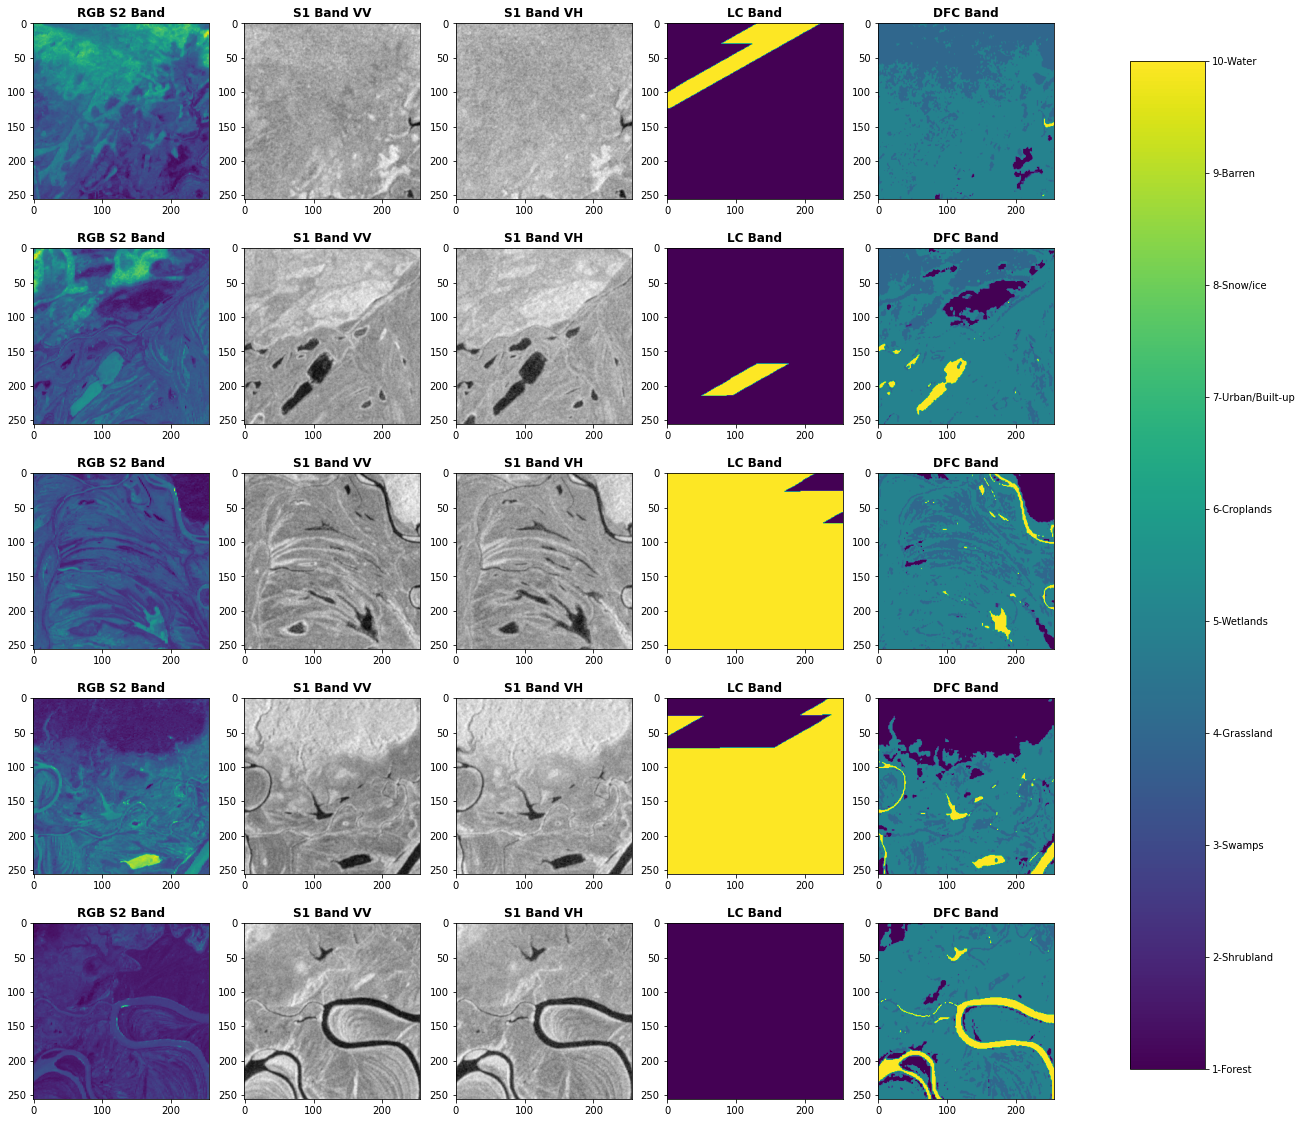

In [221]:
fig, axs = plt.subplots(5,5, figsize=(21,20))
for i in range(5):
    if i < 5:
        plot.show(s2[i+5,0,:,:],ax = axs[i][0], title="RGB S2 Band")
        plot.show(s1[i+5,0,:,:],ax = axs[i][1],cmap='gray', title="S1 Band VV")
        plot.show(s1[i+5,1,:,:],ax = axs[i][2],cmap='gray', title="S1 Band VH")
        plot.show(lc[i+5,0,:,:],ax = axs[i][3], title="LC Band")
        x = plot.show(dfc[i+5,0,:,:],ax = axs[i][4], title="DFC Band")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax, ticks = [1,2,3,4,5,6,7,8,9,10])

cbar.ax.set_yticklabels(["1-Forest", "2-Shrubland","3-Swamps","4-Grassland","5-Wetlands","6-Croplands","7-Urban/Built-up","8-Snow/ice","9-Barren","10-Water"])
plt.show()